## **Air quality - GIOS data analysis**
### Advanced Databases
### Automatic Control and Robotic, Cyber-physical Systems
#### **Daniel Jurkowski (407200) & Adam Pękala (405380) & Rafał Maciasz (000000) & Jakub Sacha (000000)**

### **1. Import required packages** 

In [23]:
import psycopg2
import requests
import pandas as pd
import matplotlib.pyplot as plt
import schedule
import time

### **2. Connect to database**

In [24]:
db_name = 'gios_data'
db_user = 'postgres'
db_password = 'kochamadb'
db_host = 'localhost'
db_port = '5000'

conn = psycopg2.connect(
    dbname=db_name,
    user=db_user,
    password=db_password,
    host=db_host,
    port=db_port
)

### **3. Scrap data from chosen API.**

**3.1. GET /pjp-api/rest/station/findAll** - List of all sensors

In [25]:
# Get all sensors id's
def get_all_ids():
    response = requests.get("https://api.gios.gov.pl/pjp-api/rest/station/findAll")
    data = response.json()

    ids = [station['id'] for station in data]
    return ids

**3.2. GET /pjp-api/v1/rest/data/getData/{idSensor}**  - Network service making available measurement data based on the given measurement site ID, from the last full hour up to the third day back. The measurement results are made available in local time, i.e. in summer in CEST time (UTC+ 02:00, Central European Summer Time), in winter in CET time (UTC+ 01:00, Central European Winter Time).

In [26]:
cur = conn.cursor()

cur.execute('''
CREATE TABLE IF NOT EXISTS actual_measurements (
    station_id VARCHAR(255),
    date_time TIMESTAMP,
    value DECIMAL
);
''')
conn.commit()

def insert_data_to_db(conn, data):
    cur = conn.cursor()
    if data['Lista danych pomiarowych']:
        for measurement in data['Lista danych pomiarowych']:
            cur.execute('''
                INSERT INTO actual_measurements (station_id, date_time, value)
                VALUES (%s, %s, %s);
            ''', (
                measurement['Kod stanowiska'],
                measurement['Data'],
                measurement['Wartość']
            ))
        conn.commit()

def fetch_data_from_api(api_url):
    response = requests.get(api_url)
    if response.status_code == 200:
        return response.json()
    else:
        return None
    
all_ids = get_all_ids()

for id in all_ids:
    api_url = f'https://api.gios.gov.pl/pjp-api/v1/rest/data/getData/{id}'

    data = fetch_data_from_api(api_url)

    if data:
        insert_data_to_db(conn, data)
    

**3.3. GET - /pjp-api/v1/rest/archivalData/getDataBySensor/{idSensor}** - A web service that makes available archival measurement data based on the given measurement site ID. One-hour measurement results are always made available in CET time (UTC+ 01:00, Central European Winter Time).

We have selected a query retrieving data on pollution from all sensors for the last 30 days.

approx time ~ 11min

In [27]:
# cur = conn.cursor()

# cur.execute('''
# CREATE TABLE IF NOT EXISTS archive_measurements(
#     station_id VARCHAR(255),
#     date_time TIMESTAMP,
#     value DECIMAL
# );
# ''')
# conn.commit()

# def insert_data_to_db(conn, data):
#     cur = conn.cursor()
#     if data['Lista archiwalnych wyników pomiarów']:
#         for measurement in data['Lista archiwalnych wyników pomiarów']:
#             cur.execute('''
#                 INSERT INTO archive_measurements (station_name, station_id, date_time, value)
#                 VALUES (%s, %s, %s, %s);
#             ''', (
#                 measurement['Nazwa stacji'],
#                 measurement['Kod stanowiska'],
#                 measurement['Data'],
#                 measurement['Wartość']
#             ))
#         conn.commit()

# def fetch_data_from_api(api_url):
#     response = requests.get(api_url)
#     if response.status_code == 200:
#         return response.json()
#     else:
#         return None
    
# for id in all_ids:
#     api_url = f'https://api.gios.gov.pl/pjp-api/v1/rest/archivalData/getDataBySensor/{id}?dayNumber=30?size=500'

#     data = fetch_data_from_api(api_url)

#     if data:
#         insert_data_to_db(conn, data)


**3.4. GET - /pjp-api/v1/rest/aqindex/getIndex/{stationId}** - Network service providing an air quality index based on the given measuring station identifier.


In order to realise real-time data download to the database, the script is placed in a docker container so that it works independently of the machine on which the rest of the code is executed. 

service_code.py

docker build -t service_air_index_live .

docker run -d --name service_container service_air_index_live

docker start service_container

           station_id           date_time    value
0  DsCzerStraza-O3-1g 2024-05-06 19:00:00  71.9683
1  DsCzerStraza-O3-1g 2024-05-06 20:00:00    65.98
2  DsCzerStraza-O3-1g 2024-05-06 21:00:00  61.7083
3  DsCzerStraza-O3-1g 2024-05-06 22:00:00  56.7717
4  DsCzerStraza-O3-1g 2024-05-06 23:00:00  59.7617


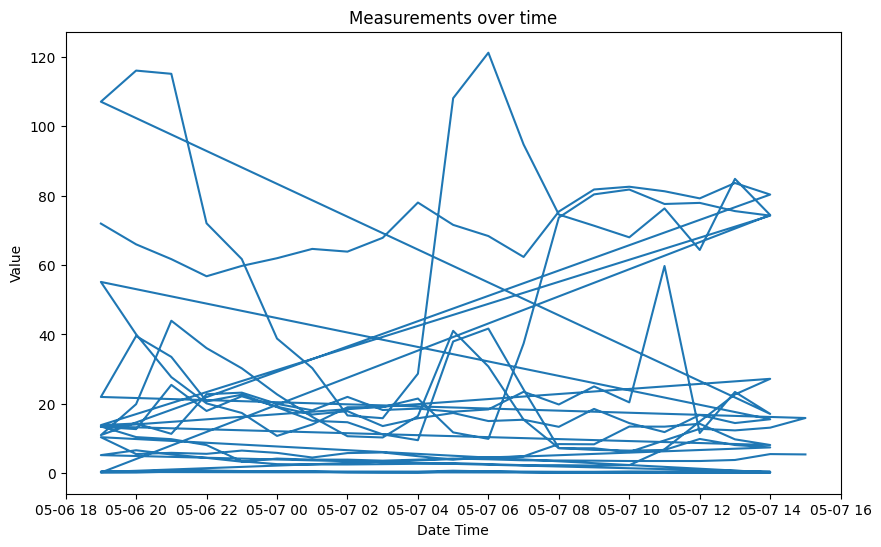

In [ ]:
#### TEST ####
cur.execute("SELECT * FROM archive_measurements;")

rows = cur.fetchall()

cur.close()
conn.close()

df = pd.DataFrame(rows, columns=['station_id', 'date_time', 'value'])

print(df.head())

plt.figure(figsize=(10,6))
plt.plot(df['date_time'], df['value'])
plt.xlabel('Date Time')
plt.ylabel('Value')
plt.title('Measurements over time')
plt.show()